In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2016-08-23
            Precipitation
Date                     
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45
2017-08-22           0.00


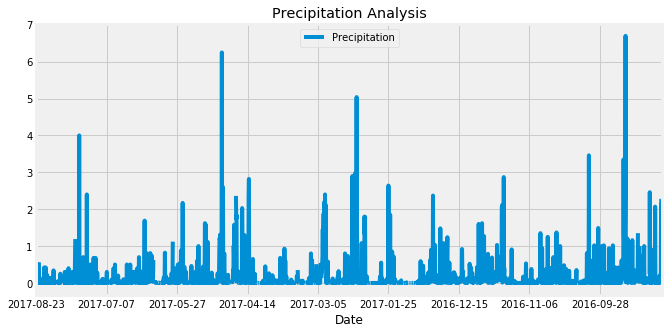

In [10]:
from datetime import datetime
import numpy as np
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
maxdate=session.query(func.max(Measurement.date )).scalar()
print (maxdate)
maxdate=datetime.strptime(maxdate, '%Y-%m-%d')
cutofdate = maxdate.replace(maxdate.year - 1).strftime('%Y-%m-%d')
print (cutofdate)
# Perform a query to retrieve the data and precipitation scores
prec_data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>cutofdate).order_by(Measurement.date.desc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
#print(prec_data)
df = pd.DataFrame(prec_data, columns=["Date","Precipitation"])
df.set_index("Date", inplace=True)
# Sort the dataframe by date
print(df.head())
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.legend(loc='upper center')
plt.savefig("images/precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
count=session.query(Measurement.station).distinct().count()
print (count)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)). group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

low_high_avg_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
low_high_avg_temp

[(54.0, 85.0, 71.66378066378067)]

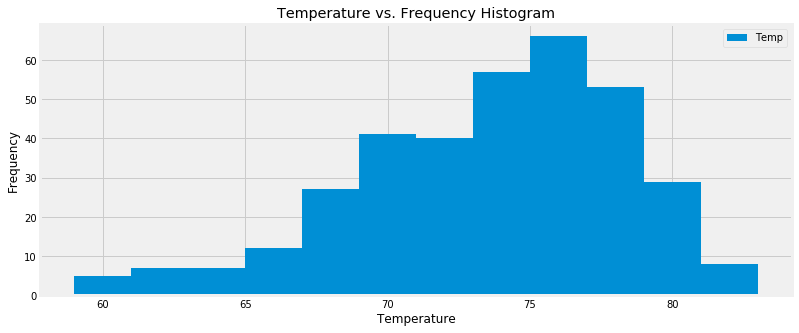

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
cutofdate
temperature_data = session.query(Measurement.tobs).filter(Measurement.date >= cutofdate).filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()
temperature_data_df = pd.DataFrame(temperature_data, columns=["Temp"])
temperature_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(12,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.savefig("images/Histogram_temperature_vs_frequency.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = datetime.strptime('2018-02-14', '%Y-%m-%d').date()
trip_end_date = datetime.strptime('2018-02-28', '%Y-%m-%d').date()
prev_yr_start_date= trip_start_date.replace(trip_start_date.year - 1).strftime('%Y-%m-%d')
prev_yr_end_date= trip_end_date.replace(trip_end_date.year - 1).strftime('%Y-%m-%d') 
minmaxavg=calc_temps(prev_yr_start_date,prev_yr_end_date)
tmin=minmaxavg[0][0]
tavg=minmaxavg[0][1]
tmax=minmaxavg[0][2]
print (f'{tmin},{tavg},{tmax}')


61.0,70.8695652173913,79.0


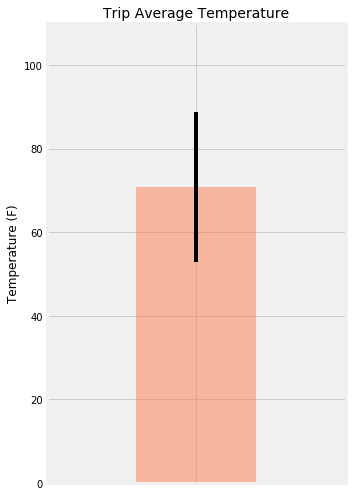

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(5,7))
plt.xlim(0, 2)
plt.ylim([0,110])
plt.bar(1, tavg, color = 'coral', yerr = tmax-tmin, tick_label="", align='center',alpha=0.5)
plt.title(f"Trip Average Temperature", fontsize=14)
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("images/trip_average_temperature.png")
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

weather_data=session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= prev_yr_start_date)\
.filter(Measurement.date <= prev_yr_end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()
#print(weather_data)
weather_data_df = pd.DataFrame(weather_data,columns=['station','prcp', 'name','elevation','latitude', 'longitude'])
weather_data_df

,station,prcp,name,elevation,latitude,longitude
0,USC00516128,1.40,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250
1,USC00519281,1.06,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889
2,USC00513117,1.02,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150
3,USC00519523,0.87,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139
4,USC00514830,0.83,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740
5,USC00519397,0.23,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680
6,USC00517948,0.17,"PEARL CITY, HI US",11.9,21.39340,-157.97510


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
